# Predicting Wind Turbine Output with a Random Forest Regression

In [1]:
'''
Read in the wind turbine data, store them in a Pandas dataframe, and rearrange them
to facilitate further analysis.

Records in the input csv file have the following form:

ID, ZONEID, TIMESTAMP, TARGETVAR, U10, V10, U100, V100

where:

ID =         Unique ID for each observation
ZONEID =     Zone/Turbine ID, a number between 1 and 10
TIMESTAMP =  Time of observation, in the format "YYYYMMDD h:mm" or "YYYYMMDD hh:mm"
TARGETVAR =  Wind turbine output
U10 =        Zonal Wind Vector at 10 m
V10 =        Meridional Wind Vector at 10 m
U100 =       Zonal Wind vector at 100 m
V100 =       Meridional Wind vector at 100 m
'''
import pandas as pd
import numpy as np

# Read in the windmill data, parsing the third column as datetimes. Make a hierarchical
# index out of the timestamp and zone id columns.  Then drop the measurement ID column.
df0 = pd.read_csv("data/Train_O4UPEyW.csv", header=0, parse_dates=[2], index_col=[2,1])
df0 = df0.drop('ID',1)

# Unstack the inner level of the index. The index is thus reduced to the timestamp, and 
# the zone ids become subcolumns to the existing columns.
df1 = df0.unstack()

# Put the timestamp index back as a dataframe column, extract year, day of year, and hour, 
# then drop the timestamp column
df2              = df1.reset_index()
df2["YEAR"]      = df2["TIMESTAMP"].map(lambda x: x.year)
df2["DAYOFYEAR"] = df2["TIMESTAMP"].map(lambda x: x.timetuple().tm_yday)
df2["HOUR"]      = df2["TIMESTAMP"].map(lambda x: x.hour)
df2              = df2.drop('TIMESTAMP',axis=1,level=0)

print('\nDataframe df2:\n%s' %df2.head())
#print('\nData Types in df2:\n%s' %df2.dtypes)

# Convert pandas dataframe to its numpy representation, separating out features from target variable.
features = [item for item in df2.columns.values.tolist() if item[0]!="TARGETVAR"]
targets  = [("TARGETVAR",i) for i in range(1,11)]
X_all    = df2.as_matrix(columns=features)
y_all    = df2.as_matrix(columns=targets)
print('\nShape of X_all: %s, shape of y_all: %s\n' %(X_all.shape, y_all.shape))
print('Number of turbine output measurements:            %i' %(df0.TARGETVAR.count()))
print('Number of turbine output measurements equal to 0: %i' %(df0.TARGETVAR[df0.TARGETVAR==0].count()))
print('Number of turbine output measurements equal to 1: %i' %(df0.TARGETVAR[df0.TARGETVAR==1].count()))


Dataframe df2:
       TARGETVAR                                                              \
ZONEID         1         2         3         4         5         6         7   
0       0.000000  0.596273  0.425465  0.378229  0.273678  0.268101  0.000000   
1       0.054879  0.411180  0.363851  0.063012  0.086796  0.034542  0.014708   
2       0.110234  0.167243  0.297129  0.036704  0.006811  0.020621  0.035098   
3       0.165116  0.037326  0.235438  0.034342  0.018646  0.001867  0.045055   
4       0.156940  0.051206  0.120904  0.033554  0.034812  0.015174  0.050160   

                                ...       V100                                \
ZONEID         8    9        10 ...          4         5         6         7   
0       0.000000  0.0  0.594361 ...  -4.486657 -4.486657 -2.956134  0.298533   
1       0.014954  0.0  0.569679 ...  -3.213752 -3.213752 -1.937051  0.797498   
2       0.071785  0.0  0.330539 ...  -2.418119 -2.418119 -1.260735  1.626758   
3       0.066796  0.0  

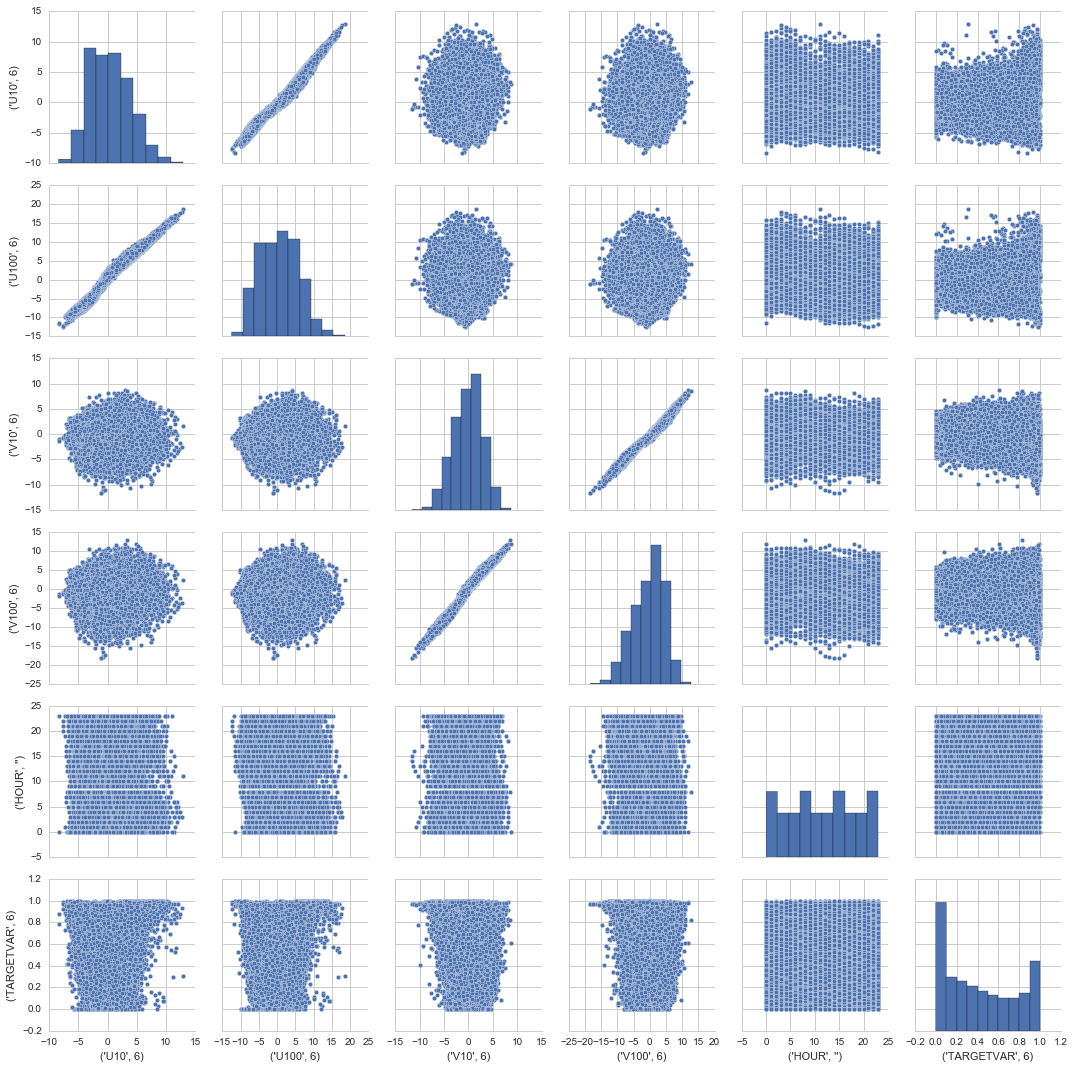

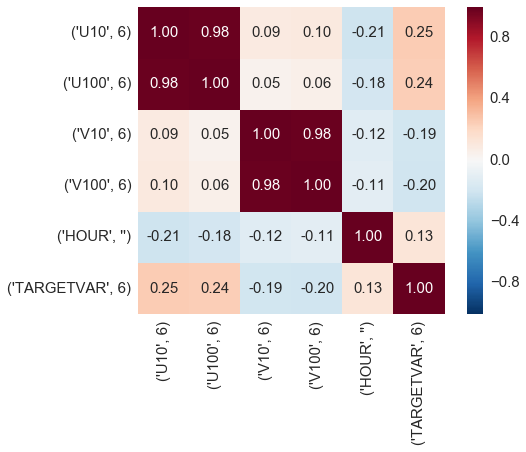

In [2]:
'''
Let's make some plots.
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scatter plot matrix
sns.set(style='whitegrid', context='notebook')
turb = 2
cols = [('U10',turb), ('U100',turb), ('V10',turb), ('V100',turb), ('HOUR',''), ('TARGETVAR',turb)]
sns.pairplot(df2[cols], size=2.5)
plt.show()

# Correlation matrix
cm = np.corrcoef(df2[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, 
                 yticklabels=cols, xticklabels=cols)
plt.show()

# Reset style settings to matplotlib defaults
sns.reset_orig()

## Analysis of one turbine only

In [3]:
'''
Try fitting for one turbine output first.
'''
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Pick a turbine and random forest parameters
y_all_1 = y_all[:,1] # Turbine no.2
mx_dpth = 20
mn_s_lf = 5
n_trees = 250
fname   = '%i_%i_%i' %(mx_dpth,mn_s_lf,n_trees)
# Create training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_1, test_size=0.30, random_state=0)

rfr = RandomForestRegressor(n_estimators=n_trees, criterion="mse", max_depth=mx_dpth, min_samples_split=2, 
                      min_samples_leaf=mn_s_lf, max_features="sqrt", max_leaf_nodes=None, bootstrap=True,
                      oob_score=True, n_jobs=-1, random_state=0, verbose=0)

# Fit to training data.
%time rfr.fit(X_train, y_train)

CPU times: user 15.3 s, sys: 110 ms, total: 15.5 s
Wall time: 4.59 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

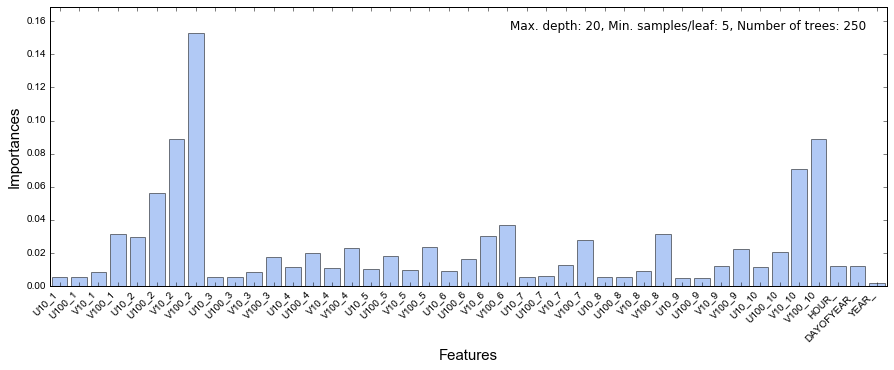


Results:
                            Train     Test
Number of instances =       9709,     4162
Mean y_true =               0.309106, 0.311318
Mean y_pred =               0.309191, 0.313073
Minimum y_pred =            0.026811, 0.029805
Maximum y_pred =            0.954538, 0.919032
Standard deviation y_true = 0.259665, 0.263519
Standard deviation y_pred = 0.224351, 0.216570
RMSE =                      0.077745, 0.114163
R^2 =                       0.910357, 0.812315
 


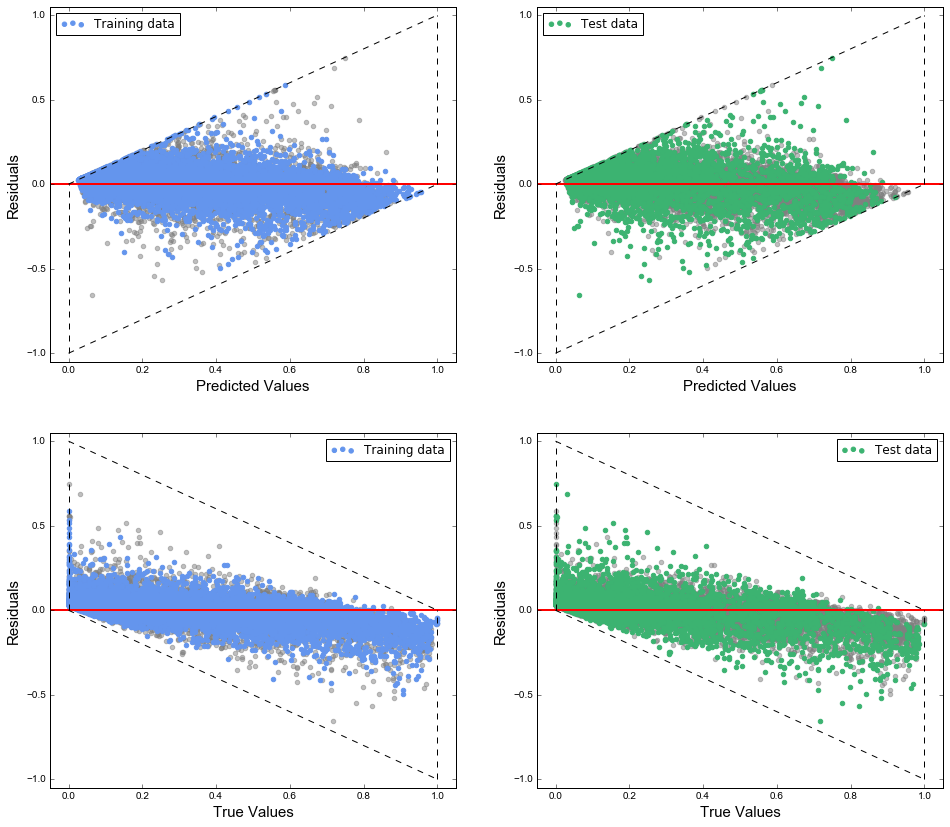

In [4]:
'''
Examine fit results.
'''
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

# Plot feature importances
FeatureImportances = {feature: importance for (feature,importance) in zip(features,rfr.feature_importances_)}
OrderedFeatures    = [(obs,i) for i in range(1,11) for obs in ('U10','U100','V10','V100')]
OrderedFeatures.append(('HOUR', ''))
OrderedFeatures.append(('DAYOFYEAR', ''))
OrderedFeatures.append(('YEAR', ''))
FeatureLabels      = [item[0]+'_'+str(item[1]) for item in OrderedFeatures]
OrderedImportances = [FeatureImportances[feature] for feature in OrderedFeatures]
maxHeight          = 1.10*max(OrderedImportances)
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(15,5) )
bins      = np.arange(43)
axes.bar(bins, OrderedImportances, align="center", color="cornflowerblue", alpha=0.5)
axes.set_xlabel("Features", fontsize=15)
axes.set_xticks(bins)
axes.set_xticklabels(FeatureLabels, ha="right", rotation=45.)
axes.set_xlim([-0.5, bins.size-0.5])
axes.set_ylabel("Importances", fontsize=15)
axes.set_ylim([0.0, maxHeight])
axes.text(0.55, 0.92, 
          'Max. depth: {0}, Min. samples/leaf: {1}, Number of trees: {2}'.format(mx_dpth,mn_s_lf,n_trees),
          fontsize=12, transform=axes.transAxes)
plt.show()
fig.savefig('FeatureImportances_'+fname+'.png', dpi=200, bbox_inches='tight')

# Make predictions on train and test set and compute evaluation metric (RMSE).
y_test_pred  = rfr.predict(X_test)
y_train_pred = rfr.predict(X_train)
print('\nResults:')
print('                            Train     Test')
print('Number of instances =       %i,     %i' %(len(y_train),len(y_test)))
print('Mean y_true =               %f, %f' %(y_train.mean(),y_test.mean()))
print('Mean y_pred =               %f, %f' %(y_train_pred.mean(),y_test_pred.mean()))
print('Minimum y_pred =            %f, %f' %(y_train_pred.min(),y_test_pred.min()))
print('Maximum y_pred =            %f, %f' %(y_train_pred.max(),y_test_pred.max()))
print('Standard deviation y_true = %f, %f' %(y_train.std(),y_test.std()))
print('Standard deviation y_pred = %f, %f' %(y_train_pred.std(),y_test_pred.std()))
print('RMSE =                      %f, %f'\
      %(np.sqrt(mean_squared_error(y_train,y_train_pred)),np.sqrt(mean_squared_error(y_test,y_test_pred))))
print('R^2 =                       %f, %f'\
      %(r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred)))
print(' ')

# Plot residuals
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(16,14))
axes[0,0].scatter(y_test_pred, y_test_pred-y_test, color="grey", alpha=0.5, marker="o")
axes[0,0].scatter(y_train_pred, y_train_pred-y_train, color="cornflowerblue", marker="o", label="Training data")
axes[0,0].set_xlabel("Predicted Values", fontsize=15)
axes[0,0].set_ylabel("Residuals", fontsize=15)
axes[0,0].legend(loc="upper left")
axes[0,0].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
xval = np.array([0.0,1.0])
axes[0,0].plot(xval, xval, 'k--')
axes[0,0].plot(xval, xval-1.0, 'k--')
axes[0,0].vlines(x=[0.0,1.0], ymin=[-1.0,0.0], ymax=[0.0,1.0], linestyles='dashed')
axes[0,0].set_xlim([-0.05, 1.05])
axes[0,0].set_ylim([-1.05, 1.05])

axes[0,1].scatter(y_train_pred, y_train_pred-y_train, color="grey", alpha=0.5, marker="o")
axes[0,1].scatter(y_test_pred, y_test_pred-y_test, color="mediumseagreen", marker="o", label="Test data")
axes[0,1].set_xlabel("Predicted Values", fontsize=15)
axes[0,1].set_ylabel("Residuals", fontsize=15)
axes[0,1].legend(loc="upper left")
axes[0,1].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
axes[0,1].plot(xval, xval, 'k--')
axes[0,1].plot(xval, xval-1.0, 'k--')
axes[0,1].vlines(x=[0.0,1.0], ymin=[-1.0,0.0], ymax=[0.0,1.0], linestyles='dashed')
axes[0,1].set_xlim([-0.05, 1.05])
axes[0,1].set_ylim([-1.05, 1.05])

axes[1,0].scatter(y_test, y_test_pred-y_test, color="grey", alpha=0.5, marker="o")
axes[1,0].scatter(y_train, y_train_pred-y_train, color="cornflowerblue", marker="o", label="Training data")
axes[1,0].set_xlabel("True Values", fontsize=15)
axes[1,0].set_ylabel("Residuals", fontsize=15)
axes[1,0].legend(loc="upper right")
axes[1,0].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
axes[1,0].plot(xval, -xval, 'k--')
axes[1,0].plot(xval, 1.0-xval, 'k--')
axes[1,0].vlines(x=[0.0,1.0], ymin=[0.0,-1.0], ymax=[1.0,0.0], linestyles='dashed')
axes[1,0].set_xlim([-0.05, 1.05])
axes[1,0].set_ylim([-1.05, 1.05])

axes[1,1].scatter(y_train, y_train_pred-y_train, color="grey", alpha=0.5, marker="o")
axes[1,1].scatter(y_test, y_test_pred-y_test, color="mediumseagreen", marker="o", label="Test data")
axes[1,1].set_xlabel("True Values", fontsize=15)
axes[1,1].set_ylabel("Residuals", fontsize=15)
axes[1,1].legend(loc="upper right")
axes[1,1].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
axes[1,1].plot(xval, -xval, 'k--')
axes[1,1].plot(xval, 1.0-xval, 'k--')
axes[1,1].vlines(x=[0.0,1.0], ymin=[0.0,-1.0], ymax=[1.0,0.0], linestyles='dashed')
axes[1,1].set_xlim([-0.05, 1.05])
axes[1,1].set_ylim([-1.05, 1.05])
plt.show()
fig.savefig('Residuals_'+fname+'.png', dpi=200, bbox_inches='tight')

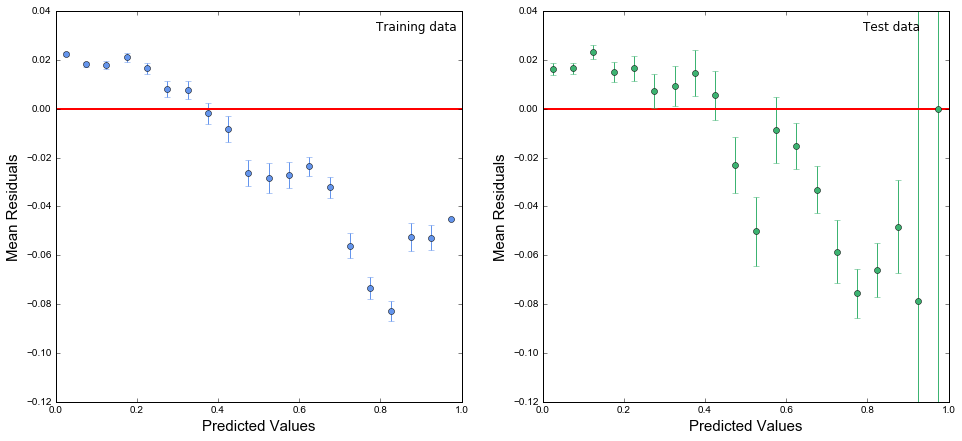

In [13]:
'''
Make profile histograms of the residuals.
'''
import numpy as np

def profile( x, y, nbins, xmin, xmax, fmean, fstd ):
    '''
    Given two data arrays of the same length x and y, computes a profile
    histogram of nbins between xmin and xmax. Returns the bin centers in
    xmids, and the y means and standard deviations within bins in ymeans
    and ystds. fmean is a fake mean to be used when a bin is empty, and
    fstd is a fake standard deviation to be used when a bin contains only
    one element.
    '''
    deltax = (xmax-xmin)/nbins
    xbins  = np.arange(xmin, xmax+deltax, deltax)
    xmids  = [(xbins[ind]+xbins[ind+1])/2 for ind in range(nbins)]
    xf     = np.array(x).flatten()
    yf     = np.array(y).flatten()
    ymeans = []
    ystds  = []
    for ibin in range(nbins):
        y_elements = np.array([yval for (xval,yval) in zip(xf,yf) if xval>=xbins[ibin] and xval<xbins[ibin+1]])
        ylen       = len(y_elements)
        if ylen>0:
            ymeans.append(y_elements.mean())
        else:
            ymeans.append(fmean)
        if ylen>1:
            ystds.append(y_elements.std()/np.sqrt(ylen))
        else:
            ystds.append(fstd)
    return (xmids,ymeans,ystds)

xtn_mids,rtn_means,rtn_stds = profile( y_train_pred, y_train_pred-y_train, 20, 0.0, 1.0, 0.0, 1.0)
xtt_mids,rtt_means,rtt_stds = profile( y_test_pred, y_test_pred-y_test, 20, 0.0, 1.0, 0.0, 1.0)

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,7))
axes[0].errorbar(xtn_mids, rtn_means, yerr=rtn_stds, fmt='o', color='cornflowerblue')
axes[0].set_xlabel("Predicted Values", fontsize=15)
axes[0].set_ylabel("Mean Residuals", fontsize=15)
axes[0].text(0.79, 0.95, 'Training data', fontsize=12, transform=axes[0].transAxes)
axes[0].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([-0.12, 0.04])

axes[1].errorbar(xtt_mids, rtt_means, yerr=rtt_stds, fmt='o', color='mediumseagreen')
axes[1].set_xlabel("Predicted Values", fontsize=15)
axes[1].set_ylabel("Mean Residuals", fontsize=15)
axes[1].text(0.79, 0.95, 'Test data', fontsize=12, transform=axes[1].transAxes)
axes[1].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([-0.12, 0.04])
plt.show()

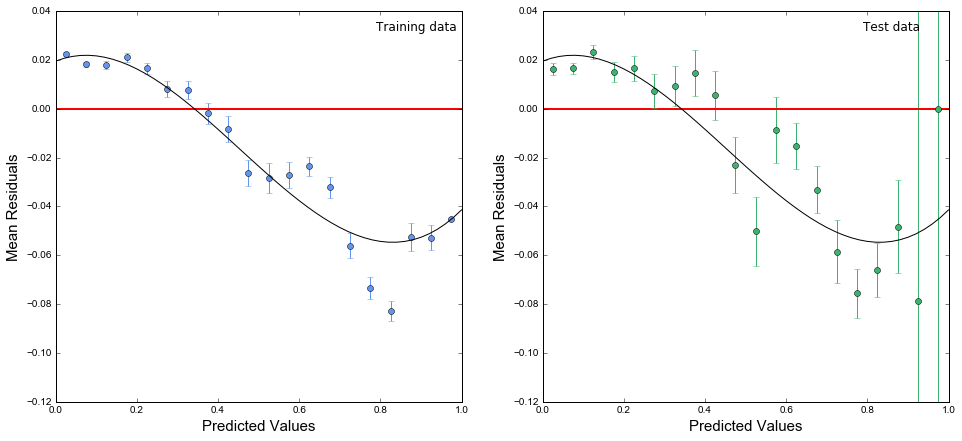


Results:
                            Train     Test
Number of instances =       9709,     4162
Mean y_true =               0.309106, 0.311318
Mean y_pred =               0.309653, 0.313688
Minimum y_pred =            0.005827, 0.008703
Maximum y_pred =            1.002348, 0.970305
Standard deviation y_true = 0.259665, 0.263519
Standard deviation y_pred = 0.249471, 0.241384
RMSE =                      0.073650, 0.111971
R^2 =                       0.919551, 0.819455
 


In [18]:
'''
Fit a smooth curve through the training data profile.
Apply corresponding bias correction to random forest regressor output, 
and recompute RMSE.
'''
import scipy.optimize as optimization

def rfbias(x, a, b, c, d):
    return a + b*x + c*x*x + d*x*x*x

fitpar,covmat = optimization.curve_fit(rfbias, xtn_mids, rtn_means, p0=None, sigma=rtn_stds, 
                                       absolute_sigma=True, check_finite=True )

xvals = np.arange(0.0,1.02,0.02)
yvals = np.array([rfbias(xval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for xval in xvals])

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,7))
axes[0].errorbar(xtn_mids, rtn_means, yerr=rtn_stds, fmt='o', color='cornflowerblue')
axes[0].plot(xvals, yvals, 'k-')
axes[0].set_xlabel("Predicted Values", fontsize=15)
axes[0].set_ylabel("Mean Residuals", fontsize=15)
axes[0].text(0.79, 0.95, 'Training data', fontsize=12, transform=axes[0].transAxes)
axes[0].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([-0.12, 0.04])

axes[1].errorbar(xtt_mids, rtt_means, yerr=rtt_stds, fmt='o', color='mediumseagreen')
axes[1].plot(xvals, yvals, 'k-')
axes[1].set_xlabel("Predicted Values", fontsize=15)
axes[1].set_ylabel("Mean Residuals", fontsize=15)
axes[1].text(0.79, 0.95, 'Test data', fontsize=12, transform=axes[1].transAxes)
axes[1].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([-0.12, 0.04])
plt.show()

y_train_pred_corr = np.array([yval-rfbias(yval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for yval in y_train_pred])
y_test_pred_corr  = np.array([yval-rfbias(yval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for yval in y_test_pred])
print('\nResults:')
print('                            Train     Test')
print('Number of instances =       %i,     %i' %(len(y_train),len(y_test)))
print('Mean y_true =               %f, %f' %(y_train.mean(),y_test.mean()))
print('Mean y_pred =               %f, %f' %(y_train_pred_corr.mean(),y_test_pred_corr.mean()))
print('Minimum y_pred =            %f, %f' %(y_train_pred_corr.min(),y_test_pred_corr.min()))
print('Maximum y_pred =            %f, %f' %(y_train_pred_corr.max(),y_test_pred_corr.max()))
print('Standard deviation y_true = %f, %f' %(y_train.std(),y_test.std()))
print('Standard deviation y_pred = %f, %f' %(y_train_pred_corr.std(),y_test_pred_corr.std()))
print('RMSE =                      %f, %f'\
      %(np.sqrt(mean_squared_error(y_train,y_train_pred_corr)),np.sqrt(mean_squared_error(y_test,y_test_pred_corr))))
print('R^2 =                       %f, %f'\
      %(r2_score(y_train,y_train_pred_corr),r2_score(y_test,y_test_pred_corr)))
print(' ')

## Analysis of all turbines together

In [21]:
'''
Split data set into a part for training and a part for testing.
'''
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=0)

print('Size of full data set: %i, training set: %i, testing set: %i' %(len(y_all),len(y_train),len(y_test)))

Size of full data set: 13871, training set: 9709, testing set: 4162


In [22]:
'''
Set regressor options and fit to training data.

(This cell can be omitted if running the next cell, with the grid search.)
'''
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=2000, criterion="mse", max_depth=20, min_samples_split=2, 
                      min_samples_leaf=5, max_features="sqrt", max_leaf_nodes=None, bootstrap=True,
                      oob_score=True, n_jobs=-1, random_state=0, verbose=0)

# Fit to training data.
%time rfr.fit(X_train, y_train)

CPU times: user 2min 45s, sys: 870 ms, total: 2min 46s
Wall time: 47.8 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

In [41]:
'''
Do a grid search to find optimal hyper-parameters of the random forest regressor.
We use the RMSE to score parameter choices.

(This cell can be omitted if the previous one was run.)
'''
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Specify the parameter grid to be searched
parameter_grid = [{'n_estimators': [500, 1000, 2000], 'max_depth': [30, 40, 50], 
                   'min_samples_leaf': [1, 2, 5]}]

# Start the grid search
rfo = GridSearchCV(RandomForestRegressor(criterion='mse', min_samples_split=2, max_features="sqrt",
                                         max_leaf_nodes=None, bootstrap=True, oob_score=True, 
                                         n_jobs=-1, random_state=0, verbose=0),
                   parameter_grid, refit=True, cv=5, scoring='mean_squared_error')
%time rfo.fit(X_train, y_train)

# Print out the results (flipping the sign on the grid scores to make them positive again).
print("Best parameter values found on development set:")
print(" ")
print(rfo.best_params_)
print(" ")
print("Grid scores on development set:")
print(" ")
for params, mean_score, scores in rfo.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" %(-mean_score, scores.std()*2, params))

# Retrieve best random forest model from grid search
rfr = rfo.best_estimator_
print("\nBest estimator:\n%s" %rfr)

CPU times: user 3h 25min 3s, sys: 4min 54s, total: 3h 29min 58s
Wall time: 1h 3min 20s
Best parameter values found on development set:
 
{'n_estimators': 2000, 'max_depth': 50, 'min_samples_leaf': 1}
 
Grid scores on development set:
 
0.018 (+/-0.001) for {'n_estimators': 500, 'max_depth': 30, 'min_samples_leaf': 1}
0.018 (+/-0.001) for {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 1}
0.018 (+/-0.001) for {'n_estimators': 2000, 'max_depth': 30, 'min_samples_leaf': 1}
0.020 (+/-0.001) for {'n_estimators': 500, 'max_depth': 30, 'min_samples_leaf': 2}
0.020 (+/-0.001) for {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 2}
0.020 (+/-0.001) for {'n_estimators': 2000, 'max_depth': 30, 'min_samples_leaf': 2}
0.022 (+/-0.001) for {'n_estimators': 500, 'max_depth': 30, 'min_samples_leaf': 5}
0.022 (+/-0.001) for {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 5}
0.022 (+/-0.001) for {'n_estimators': 2000, 'max_depth': 30, 'min_samples_leaf': 5}
0.018 (+/-0

Estimator currently in use:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)



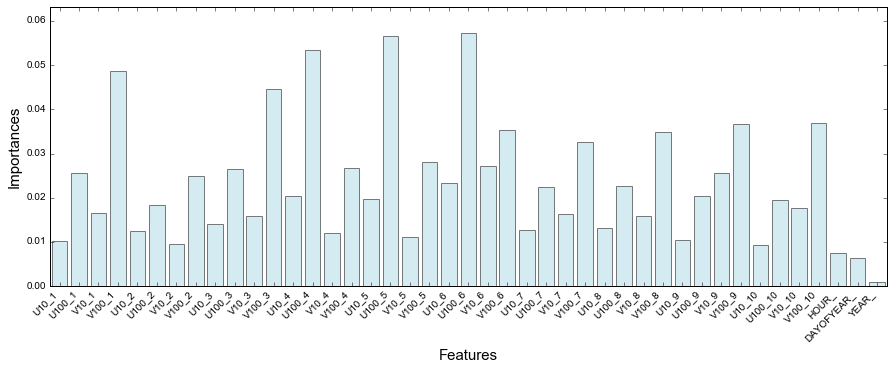


Results:
                                  Train     Test
Number of instances =             9709,     4162
Mean y_true =                     0.343296, 0.347886
Mean y_pred =                     0.342947, 0.346826
Minimum y_pred =                  0.008740, 0.009871
Maximum y_pred =                  0.962736, 0.959848
Standard deviation y_true =       0.303602, 0.307259
Standard deviation y_pred =       0.249513, 0.244680
RMSE (uniform average) =          0.116164, 0.146385
R^2 (uniform average) =           0.844772, 0.759930
R^2 (variance weighted average) = 0.846999, 0.762251
 


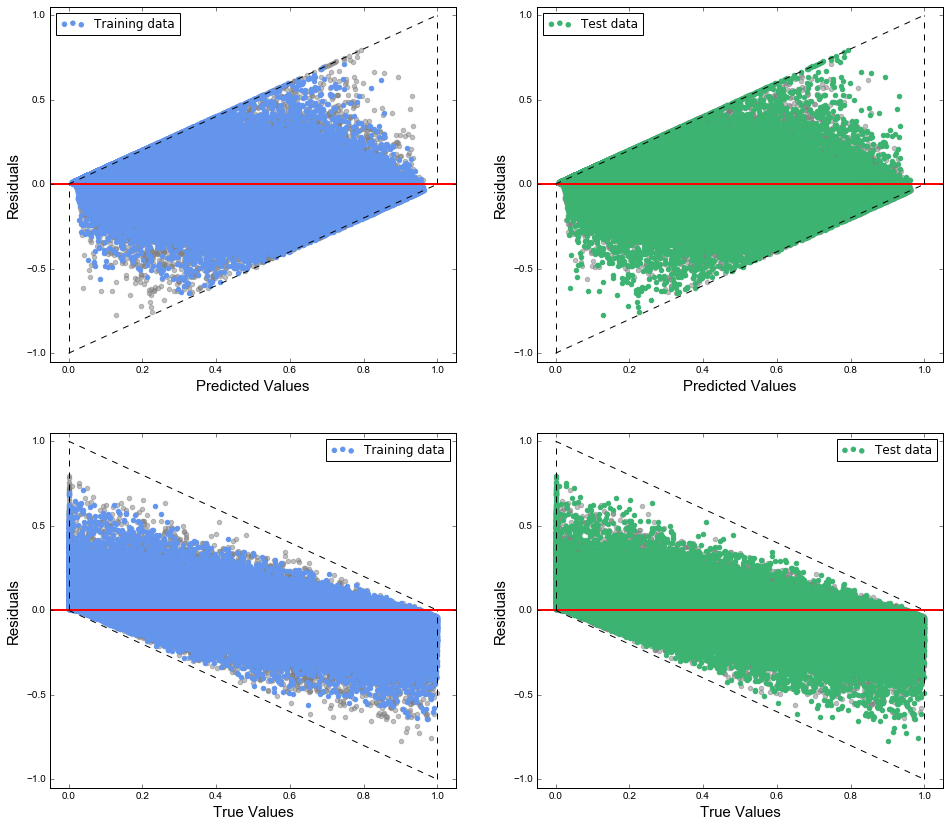

In [35]:
'''
Examine fit results.
'''
from sklearn.metrics import mean_squared_error, r2_score

print("Estimator currently in use:\n\n%s\n" %rfr)

# Make a plot of feature importances.
FeatureImportances = {feature: importance for (feature,importance) in zip(features,rfr.feature_importances_)}
OrderedFeatures    = [(obs,i) for i in range(1,11) for obs in ('U10','U100','V10','V100')]
OrderedFeatures.append(('HOUR', ''))
OrderedFeatures.append(('DAYOFYEAR', ''))
OrderedFeatures.append(('YEAR', ''))
FeatureLabels      = [item[0]+'_'+str(item[1]) for item in OrderedFeatures]
OrderedImportances = [FeatureImportances[feature] for feature in OrderedFeatures]
maxHeight          = 1.10*max(OrderedImportances)
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(15,5) )
bins      = np.arange(43)
axes.bar(bins, OrderedImportances, align="center", color="lightblue", alpha=0.5)
axes.set_xlabel("Features", fontsize=15)
axes.set_xticks(bins)
axes.set_xticklabels(FeatureLabels, ha="right", rotation=45.)
axes.set_xlim([-0.5, bins.size-0.5])
axes.set_ylabel("Importances", fontsize=15)
axes.set_ylim([0.0, maxHeight])
plt.show()
#fig.savefig('FeatureImportances.png', dpi=200, bbox_inches='tight')

# Make predictions on train and test set and compute evaluation metric (RMSE).
y_test_pred  = rfr.predict(X_test)
y_train_pred = rfr.predict(X_train)
print('\nResults:')
print('                                  Train     Test')
print('Number of instances =             %i,     %i' %(len(y_train),len(y_test)))
print('Mean y_true =                     %f, %f' %(y_train.mean(),y_test.mean()))
print('Mean y_pred =                     %f, %f' %(y_train_pred.mean(),y_test_pred.mean()))
print('Minimum y_pred =                  %f, %f' %(y_train_pred.min(),y_test_pred.min()))
print('Maximum y_pred =                  %f, %f' %(y_train_pred.max(),y_test_pred.max()))
print('Standard deviation y_true =       %f, %f' %(y_train.std(),y_test.std()))
print('Standard deviation y_pred =       %f, %f' %(y_train_pred.std(),y_test_pred.std()))
print('RMSE (uniform average) =          %f, %f'\
      %(np.sqrt(mean_squared_error(y_train,y_train_pred,multioutput='uniform_average')),
        np.sqrt(mean_squared_error(y_test,y_test_pred,multioutput='uniform_average'))))
print('R^2 (uniform average) =           %f, %f'\
      %(r2_score(y_train,y_train_pred,multioutput='uniform_average'),
        r2_score(y_test,y_test_pred,multioutput='uniform_average')))
print('R^2 (variance weighted average) = %f, %f'\
      %(r2_score(y_train,y_train_pred,multioutput='variance_weighted'),
        r2_score(y_test,y_test_pred,multioutput='variance_weighted')))
print(' ')

# Plot residuals
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(16,14))
axes[0,0].scatter(y_test_pred, y_test_pred-y_test, color="grey", alpha=0.5, marker="o")
axes[0,0].scatter(y_train_pred, y_train_pred-y_train, color="cornflowerblue", marker="o", label="Training data")
axes[0,0].set_xlabel("Predicted Values", fontsize=15)
axes[0,0].set_ylabel("Residuals", fontsize=15)
axes[0,0].legend(loc="upper left")
axes[0,0].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
xval = np.array([0.0,1.0])
axes[0,0].plot(xval, xval, 'k--')
axes[0,0].plot(xval, xval-1.0, 'k--')
axes[0,0].vlines(x=[0.0,1.0], ymin=[-1.0,0.0], ymax=[0.0,1.0], linestyles='dashed')
axes[0,0].set_xlim([-0.05, 1.05])
axes[0,0].set_ylim([-1.05, 1.05])

axes[0,1].scatter(y_train_pred, y_train_pred-y_train, color="grey", alpha=0.5, marker="o")
axes[0,1].scatter(y_test_pred, y_test_pred-y_test, color="mediumseagreen", marker="o", label="Test data")
axes[0,1].set_xlabel("Predicted Values", fontsize=15)
axes[0,1].set_ylabel("Residuals", fontsize=15)
axes[0,1].legend(loc="upper left")
axes[0,1].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
axes[0,1].plot(xval, xval, 'k--')
axes[0,1].plot(xval, xval-1.0, 'k--')
axes[0,1].vlines(x=[0.0,1.0], ymin=[-1.0,0.0], ymax=[0.0,1.0], linestyles='dashed')
axes[0,1].set_xlim([-0.05, 1.05])
axes[0,1].set_ylim([-1.05, 1.05])

axes[1,0].scatter(y_test, y_test_pred-y_test, color="grey", alpha=0.5, marker="o")
axes[1,0].scatter(y_train, y_train_pred-y_train, color="cornflowerblue", marker="o", label="Training data")
axes[1,0].set_xlabel("True Values", fontsize=15)
axes[1,0].set_ylabel("Residuals", fontsize=15)
axes[1,0].legend(loc="upper right")
axes[1,0].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
axes[1,0].plot(xval, -xval, 'k--')
axes[1,0].plot(xval, 1.0-xval, 'k--')
axes[1,0].vlines(x=[0.0,1.0], ymin=[0.0,-1.0], ymax=[1.0,0.0], linestyles='dashed')
axes[1,0].set_xlim([-0.05, 1.05])
axes[1,0].set_ylim([-1.05, 1.05])

axes[1,1].scatter(y_train, y_train_pred-y_train, color="grey", alpha=0.5, marker="o")
axes[1,1].scatter(y_test, y_test_pred-y_test, color="mediumseagreen", marker="o", label="Test data")
axes[1,1].set_xlabel("True Values", fontsize=15)
axes[1,1].set_ylabel("Residuals", fontsize=15)
axes[1,1].legend(loc="upper right")
axes[1,1].hlines(y=0, xmin=-0.05, xmax=1.05, lw=2, color='red')
axes[1,1].plot(xval, -xval, 'k--')
axes[1,1].plot(xval, 1.0-xval, 'k--')
axes[1,1].vlines(x=[0.0,1.0], ymin=[0.0,-1.0], ymax=[1.0,0.0], linestyles='dashed')
axes[1,1].set_xlim([-0.05, 1.05])
axes[1,1].set_ylim([-1.05, 1.05])
plt.show()

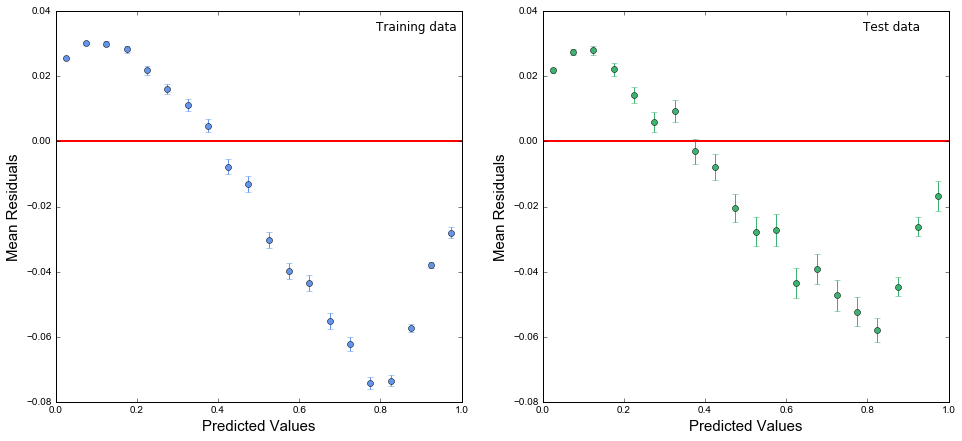

In [33]:
'''
Make profile histograms of the residuals.
'''

xtn_mids,rtn_means,rtn_stds = profile( y_train_pred, y_train_pred-y_train, 20, 0.0, 1.0, 0.0, 1.0)
xtt_mids,rtt_means,rtt_stds = profile( y_test_pred, y_test_pred-y_test, 20, 0.0, 1.0, 0.0, 1.0)

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,7))
axes[0].errorbar(xtn_mids, rtn_means, yerr=rtn_stds, fmt='o', color='cornflowerblue')
axes[0].set_xlabel("Predicted Values", fontsize=15)
axes[0].set_ylabel("Mean Residuals", fontsize=15)
axes[0].text(0.79, 0.95, 'Training data', fontsize=12, transform=axes[0].transAxes)
axes[0].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([-0.08, 0.04])

axes[1].errorbar(xtt_mids, rtt_means, yerr=rtt_stds, fmt='o', color='mediumseagreen')
axes[1].set_xlabel("Predicted Values", fontsize=15)
axes[1].set_ylabel("Mean Residuals", fontsize=15)
axes[1].text(0.79, 0.95, 'Test data', fontsize=12, transform=axes[1].transAxes)
axes[1].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([-0.08, 0.04])
plt.show()

In [ ]:
'''
Fit a smooth curve through the training data profile.
Apply corresponding bias correction to random forest regressor output, 
and recompute RMSE.
'''
import scipy.optimize as optimization

def rfbias(x, a, b, c, d):
    return a + b*x + c*x*x + d*x*x*x

fitpar,covmat = optimization.curve_fit(rfbias, xtn_mids, rtn_means, p0=None, sigma=rtn_stds, 
                                       absolute_sigma=True, check_finite=True )

xvals = np.arange(0.0,1.02,0.02)
yvals = np.array([rfbias(xval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for xval in xvals])

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,7))
axes[0].errorbar(xtn_mids, rtn_means, yerr=rtn_stds, fmt='o', color='cornflowerblue')
axes[0].plot(xvals, yvals, 'k-')
axes[0].set_xlabel("Predicted Values", fontsize=15)
axes[0].set_ylabel("Mean Residuals", fontsize=15)
axes[0].text(0.79, 0.95, 'Training data', fontsize=12, transform=axes[0].transAxes)
axes[0].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([-0.12, 0.04])

axes[1].errorbar(xtt_mids, rtt_means, yerr=rtt_stds, fmt='o', color='mediumseagreen')
axes[1].plot(xvals, yvals, 'k-')
axes[1].set_xlabel("Predicted Values", fontsize=15)
axes[1].set_ylabel("Mean Residuals", fontsize=15)
axes[1].text(0.79, 0.95, 'Test data', fontsize=12, transform=axes[1].transAxes)
axes[1].hlines(y=0, xmin=0.0, xmax=1.0, lw=2, color='red')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([-0.12, 0.04])
plt.show()

y_train_pred_corr = np.array([yval-rfbias(yval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for yval in y_train_pred])
y_test_pred_corr  = np.array([yval-rfbias(yval,fitpar[0],fitpar[1],fitpar[2],fitpar[3]) for yval in y_test_pred])
print('\nResults:')
print('                            Train     Test')
print('Number of instances =       %i,     %i' %(len(y_train),len(y_test)))
print('Mean y_true =               %f, %f' %(y_train.mean(),y_test.mean()))
print('Mean y_pred =               %f, %f' %(y_train_pred_corr.mean(),y_test_pred_corr.mean()))
print('Minimum y_pred =            %f, %f' %(y_train_pred_corr.min(),y_test_pred_corr.min()))
print('Maximum y_pred =            %f, %f' %(y_train_pred_corr.max(),y_test_pred_corr.max()))
print('Standard deviation y_true = %f, %f' %(y_train.std(),y_test.std()))
print('Standard deviation y_pred = %f, %f' %(y_train_pred_corr.std(),y_test_pred_corr.std()))
print('RMSE =                      %f, %f'\
      %(np.sqrt(mean_squared_error(y_train,y_train_pred_corr)),np.sqrt(mean_squared_error(y_test,y_test_pred_corr))))
print('R^2 =                       %f, %f'\
      %(r2_score(y_train,y_train_pred_corr),r2_score(y_test,y_test_pred_corr)))
print(' ')

## Prepare test data set for submission

In [51]:
'''
First, the best regressor found must be refitted to the entire dataset given.
'''
print("Estimator currently in use:\n\n%s\n" %rfr)

%time rfr.fit(X_all, y_all)

Estimator currently in use:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

CPU times: user 2min 7s, sys: 1 s, total: 2min 8s
Wall time: 37.5 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

In [52]:
'''
Next, prepare the given test data set in the same way as the training set, make predictions, 
and create output csv file.
'''
import csv

# Read test data into data frame, pivot it, and add time features
ttdf0              = pd.read_csv("data/Test_uP7dymh.csv", header=0, parse_dates=[2], index_col=[2,1])
ttdf1              = ttdf0.unstack()
ttdf2              = ttdf1.reset_index()
ttdf2["YEAR"]      = ttdf2["TIMESTAMP"].map(lambda x: x.year)
ttdf2["DAYOFYEAR"] = ttdf2["TIMESTAMP"].map(lambda x: x.timetuple().tm_yday)
ttdf2["HOUR"]      = ttdf2["TIMESTAMP"].map(lambda x: x.hour)
ttdf2              = ttdf2.drop('TIMESTAMP',axis=1,level=0)

# Count how many sets of observations we have in August and September 2013
nTotal             = len(ttdf2)
nAugSep2013        = len([DoY for DoY in ttdf2['DAYOFYEAR'] if DoY>212 and DoY<274])
print('\nTotal number of observation times in test set:            %i' %nTotal)
print('Number of observation times in August and September 2013: %i\n' %nAugSep2013)

# Compute predictions for test set.
features           = [item for item in ttdf2.columns.values.tolist() if item[0]!="ID"]
ttX                = ttdf2.as_matrix(columns=features)
tty                = rfr.predict(ttX).flatten()

# Generate output csv file
idset              = [("ID",i) for i in range(1,11)]
ttid               = ttdf2.as_matrix(columns=idset).flatten()
with open('data/turbineOutputsTest03.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["ID","TARGETVAR"])
    for idval,yval in zip(ttid,tty):
        writer.writerow([idval,yval])


Total number of observation times in test set:            2929
Number of observation times in August and September 2013: 1464

